In [1]:
import torch
import torchvision
import pandas as pd
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import tqdm 
import copy
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

In [2]:
# These are all of the files you are given
df_tr = pd.read_csv("kaggle_data/train.csv")

In [3]:
df_tr.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


In [4]:
def polyline_to_trip_duration(polyline):
    return max(polyline.count("[") - 2, 0) * 15

df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)

In [5]:
df_tr = df_tr[df_tr['LEN'] != 0]

In [6]:
from datetime import datetime
def parse_time(x):

    dt = datetime.fromtimestamp(x["TIMESTAMP"])
    return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

df_tr[["YR", "MON", "DAY", "HR", "WK"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

In [7]:
import math
def fillos(x):
    if x['CALL_TYPE'] == 'B':
        if type(x['ORIGIN_STAND']) == None:
            return -2
        else:
            return x['ORIGIN_STAND']
    if x['CALL_TYPE'] == 'A':
        return 0
    else:
        return -1

In [8]:
ct = pd.get_dummies(df_tr['CALL_TYPE'])
ct.columns = ['ct_A','ct_B','ct_C']

In [283]:
#drivers = pd.get_dummies(df_tr['TAXI_ID'])

In [9]:
df_tr['ORIGIN_STAND'] = df_tr.apply(fillos,axis=1)

In [10]:
stan = pd.get_dummies(df_tr['ORIGIN_STAND'])

In [149]:
df_tr.columns

Index(['TRIP_ID', 'CALL_TYPE', 'ORIGIN_CALL', 'ORIGIN_STAND', 'TAXI_ID',
       'TIMESTAMP', 'DAY_TYPE', 'MISSING_DATA', 'POLYLINE', 'LEN', 'YR', 'MON',
       'DAY', 'HR', 'WK'],
      dtype='object')

In [489]:
cols = ['LEN', 'YR','MON','DAY','HR','WK','ct_A','ct_B','ct_C']+list(stan.columns) #+ list(drivers.columns)

In [473]:
df_feat = pd.concat([df_tr,ct,stan],axis=1)
#X = df_feat[cols].to_numpy().astype(float)
#y = df_feat['LEN'].to_numpy().astype(float)

In [474]:
#from sklearn.model_selection import train_test_split

In [475]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

In [476]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [477]:
device

device(type='cpu')

In [478]:
# X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
# y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1).to(device)
# X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
# y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1).to(device)

In [492]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.dropout = nn.Dropout(p=0.3)
        self.bn1 = nn.InstanceNorm1d(hidden_size * 2)
        self.fc2 = nn.Linear(hidden_size * 2, hidden_size)
        self.decoder = nn.Linear(hidden_size, output_size)
        
    def forward(self, input_seq, hidden_state):
        output, hidden_state = self.rnn(input_seq, hidden_state)
        output = output.permute(1, 0, 2)  # Permute dimensions for batch normalization
        output = output.reshape(output.size(0), -1)  # Reshape to (batch_size, hidden_size*2)
        output = F.relu(self.bn1(self.fc1(output)))
        output = self.dropout(output)
        output = self.fc2(output)
        output = self.decoder(output)
        return output, hidden_state

In [499]:
model = RNN(input_size=73, output_size=1, hidden_size=256).to(device)

In [500]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [501]:
from torch.optim.lr_scheduler import StepLR 
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [483]:
save = {'w':None,'history':[],'mse':np.inf}

In [484]:
best_mse = save['mse']  # init to infinity
best_weights = save['w']
history_train = []
history_test = []

In [485]:
df_sorted = df_feat.sort_values(by=['TAXI_ID', 'TIMESTAMP'])

In [486]:
#input_data = df_sorted[cols].to_numpy()[:, 1:]

In [487]:
drives_by_taxi = list(df_sorted.groupby('TAXI_ID'))

In [490]:
input_data = [torch.tensor(drive[1][cols].to_numpy()[:, 1:], dtype=torch.float32) for drive in drives_by_taxi]

In [491]:
y_train = [torch.tensor(drive[1][cols].to_numpy()[:, 0], dtype=torch.float32) for drive in drives_by_taxi]

In [503]:
import numpy as np

In [504]:
shuffled_data = list(zip(input_data[:2], y_train[:2]))

In [505]:
for i_epoch in range(8):
    n=0
    running_loss = 0
    
    np.random.shuffle(shuffled_data)
    
    for x_tensor, y_tensor in zip(input_data, y_train):
        
        hidden_state = None
        input_seq = x_tensor.unsqueeze(0)
        output, _ = model(input_seq, hidden_state)

        loss = loss_fn(torch.squeeze(output.flatten()), y_tensor)
        running_loss += loss.item()
        n += x_tensor.shape[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    history_train.append(running_loss/n)
    print("Epoch: {0} \t Loss {1:.8f}".format(i_epoch + 1, running_loss/n))

C:\Users\Jimmy\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1 	 Loss 269.14342364
Epoch: 2 	 Loss 180.86928336
Epoch: 3 	 Loss 161.21087934
Epoch: 4 	 Loss 160.76168413
Epoch: 5 	 Loss 160.83330531
Epoch: 6 	 Loss 160.74900871
Epoch: 7 	 Loss 160.77952384
Epoch: 8 	 Loss 160.78152735


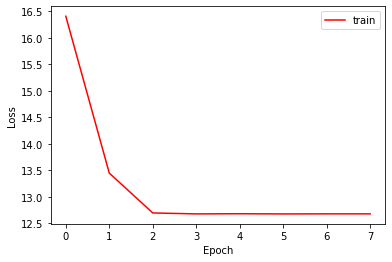

In [507]:
# Plotting both the curves simultaneously
plt.plot(np.sqrt(history_train), color='r', label='train')
#plt.plot(np.sqrt(history_test), color='g', label='test')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epoch")
plt.ylabel("Loss")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

In [510]:
test = pd.read_csv('kaggle_data/test_public.csv')
tid =  test[['TRIP_ID']]
test[["YR", "MON", "DAY", "HR", "WK"]] = test[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
test = test.sort_values(by=['TAXI_ID', 'TIMESTAMP'])
ct_test = pd.get_dummies(test['CALL_TYPE'])
ct_test.columns = ['ct_A','ct_B','ct_C']
enc = OneHotEncoder()
enc.fit(np.array(df_tr[['ORIGIN_STAND']]))
test['ORIGIN_STAND'] = test.apply(fillos,axis=1)
stan_test = pd.DataFrame(enc.transform(test[['ORIGIN_STAND']]).toarray())
stan_test.columns = stan_test.columns -1
stan_test = stan_test.drop([64],axis=1)
#drivers_test = pd.get_dummies(test['TAXI_ID'])
test = pd.concat([test,ct_test,stan_test],axis=1)
cols = ['YR','MON','DAY','HR','WK','ct_A','ct_B','ct_C']+list(stan_test.columns)#+list(drivers.columns)
#test = test[['YR','MON','DAY','HR','WK','ct_A','ct_B','ct_C']+list(stan_test.columns)]#.to_numpy().astype(float)
#test = torch.tensor(test, dtype=torch.float32).to(device)

C:\Users\Jimmy\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


In [511]:
test_drives_by_taxi = list(test.groupby('TAXI_ID')[cols])

In [512]:
test_data = [torch.tensor(drive[1].to_numpy(), dtype=torch.float32) for drive in test_drives_by_taxi]

In [514]:
preds = np.array([])
for tensor in test_data:
    preds = np.append(preds, (model(tensor.unsqueeze(0), None)[0]).detach().numpy())

In [515]:
#pred = model(test).cpu().detach().numpy().transpose()[0]
tid['TRAVEL_TIME'] = preds
tid

,TRIP_ID,TRAVEL_TIME
0,T1,773.505920
1,T2,770.444824
2,T3,774.978760
3,T4,670.308228
4,T5,784.241699
...,...,...
315,T323,701.504517
316,T324,773.132446
317,T325,766.177551
318,T326,798.220764


In [516]:
tid.to_csv('submission.csv',index=False)

In [ ]:
torch.save(best_weights, 'weight.pt')

In [ ]:
Xt = torch.tensor(X,dtype=torch.float32).to(device)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
dist = pd.DataFrame((model(Xt) - yt).cpu().detach().numpy().transpose()[0])

In [ ]:
pred = model(Xt)

In [ ]:
pred = pred.cpu().detach().numpy()

In [ ]:
pred - y

In [ ]:
tensor_3d

In [ ]:
input_data

In [ ]:
input_data